In [1]:
from IPython.display import display
from IPython.core.display import HTML
%load_ext autoreload
%load_ext time
%autoreload 2
%autosave 60
%matplotlib inline

display(HTML("<style>.container { width:80% !important; }</style>"))

The time module is not an IPython extension.


Autosaving every 60 seconds


In [2]:
import pandas as pd
import numpy as np
import folium
import geojson
import geopandas
import osmnx as ox
import networkx as nx
import seaborn as sns
from pathlib import Path
from matplotlib import pyplot as plt
from datetime import datetime, timedelta

from exploration_utils import plot_counter, plot_counters, plot_locations, inspect_diff_area, plot_scatters
from exploration_utils import plot_speed_dayline, plot_flow_dayline, compute_highway_stats

UBER_BASE = Path('/private/data/mets10/validations_ext_uber')
RELEASE_PATH = UBER_BASE / 'release20221028_historic_uber'
COUNTER_PATH = Path('/private/data/mets10/loop_counters')

### Load road graph

In [3]:
edges_df = geopandas.read_parquet(RELEASE_PATH / 'road_graph' / 'berlin' / 'road_graph_edges.parquet')
edges_df

,gkey,u,v,osmid,speed_kph,maxspeed,highway,oneway,lanes,tunnel,length_meters,geometry,name
0,172546_530313_24295532,172546,530313,24295532,50.0,50,secondary,,,,46.759468,"LINESTRING (13.35225 52.56774, 13.35266 52.56784)",Emmentaler Straße
1,172558_172559_160130963,172558,172559,160130963,50.0,50,primary,,,,164.463017,"LINESTRING (13.33737 52.55878, 13.33725 52.558...",Müllerstraße
2,172559_29688040_160130963,172559,29688040,160130963,50.0,50,primary,,,,153.966487,"LINESTRING (13.33607 52.55952, 13.33578 52.559...",Müllerstraße
3,172562_530351_4804203,172562,530351,4804203,50.0,50,primary_link,,,,23.283372,"LINESTRING (13.33066 52.56260, 13.33047 52.56253)",
4,172564_530185_4432669,172564,530185,4432669,50.0,50,secondary,,,,44.345716,"LINESTRING (13.32771 52.56405, 13.32759 52.563...",Kurt-Schumacher-Platz
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16274,6171409045_6171409044_71143837,6171409045,6171409044,71143837,50.0,50,secondary,,,,71.576136,"LINESTRING (13.39911 52.50819, 13.39949 52.50873)",Axel-Springer-Straße
16275,6172685050_26745400_417807344,6172685050,26745400,417807344,50.0,50,residential,,,,5.821343,"LINESTRING (13.36256 52.50585, 13.36258 52.50590)",Bendlerbrücke
16276,6172693100_26746095_16943617,6172693100,26746095,16943617,30.0,30,primary,,,,9.151821,"LINESTRING (13.36812 52.50590, 13.36809 52.50582)",Potsdamer Straße
16277,6173378369_426425009_132105452,6173378369,426425009,132105452,50.0,50,tertiary,,,,3.764184,"LINESTRING (13.49198 52.50117, 13.49202 52.50116)",Lückstraße


### Load loop counter locations matched

In [4]:
counters_assigned_df = geopandas.read_parquet(RELEASE_PATH / 'road_graph' / 'berlin' / 'counters_matched.parquet')
print(len(counters_assigned_df))
counters_assigned_df = counters_assigned_df[counters_assigned_df['way'] != -1]
counters_assigned_df

547


,id,lat,lon,heading,name,ways,way_dists,way,way_dist,u,v,geometry
0,100101010000167,52.433868,13.192578,225,TE001_Det_HF1,"[(268076575, 1827856523, '268076575_1827856523...","[0.26406754832700025, 32.81005424259161]",150912137,0.264068,268076575,1827856523,POINT (13.19258 52.43387)
1,100101010000268,52.433868,13.192578,225,TE001_Det_HF2,"[(268076575, 1827856523, '268076575_1827856523...","[0.26406754832700025, 32.81005424259161]",150912137,0.264068,268076575,1827856523,POINT (13.19258 52.43387)
2,100101010000369,52.433813,13.192747,45,TE002_Det_HF1,"[(268076575, 1827856523, '268076575_1827856523...",[13.200678028254265],150912137,13.200678,268076575,1827856523,POINT (13.19275 52.43381)
3,100101010000470,52.433813,13.192747,45,TE002_Det_HF2,"[(268076575, 1827856523, '268076575_1827856523...",[13.200678028254265],150912137,13.200678,268076575,1827856523,POINT (13.19275 52.43381)
4,100101010000874,52.436642,13.261301,180,TE004_Det_HF1,[],[],-1,-1.000000,-1,-1,POINT (13.26130 52.43664)
...,...,...,...,...,...,...,...,...,...,...,...,...
542,100101010097975,52.457440,13.384196,0,TE583_Det_HF2,"[(27556652, 1824003295, '27556652_1824003295_3...","[5.336229322748185, 16.103532659073107]",327627452,5.336229,27556652,1824003295,POINT (13.38420 52.45744)
543,100101010099692,52.509232,13.301719,180,TE592_Det_HF1,"[(26736176, 26736175, '26736176_26736175_31621...","[6.14839484607444, 17.77976719045062, 18.89012...",31621007,6.148395,26736176,26736175,POINT (13.30172 52.50923)
544,100101010099793,52.509232,13.301719,180,TE592_Det_HF2,"[(26736176, 26736175, '26736176_26736175_31621...","[6.14839484607444, 17.77976719045062, 18.89012...",31621007,6.148395,26736176,26736175,POINT (13.30172 52.50923)
545,100101010099894,52.508531,13.302183,0,TE593_Det_HF1,"[(26736157, 791127364, '26736157_791127364_327...","[6.50455329146837, 17.950528439866044]",327805903,6.504553,26736157,791127364,POINT (13.30218 52.50853)


In [5]:
compute_highway_stats(counters_assigned_df, edges_df)

,count,share,share_full
highway,,,
motorway,4,1 %,0.854701
primary,192,41 %,41.025641
residential,4,1 %,0.854701
secondary,249,53 %,53.205128
tertiary,19,4 %,4.059829


In [6]:
counters_assigned_df = counters_assigned_df[(counters_assigned_df['way'] != -1) & (counters_assigned_df['way'] != '-1')]
counters_assigned_df

,id,lat,lon,heading,name,ways,way_dists,way,way_dist,u,v,geometry
0,100101010000167,52.433868,13.192578,225,TE001_Det_HF1,"[(268076575, 1827856523, '268076575_1827856523...","[0.26406754832700025, 32.81005424259161]",150912137,0.264068,268076575,1827856523,POINT (13.19258 52.43387)
1,100101010000268,52.433868,13.192578,225,TE001_Det_HF2,"[(268076575, 1827856523, '268076575_1827856523...","[0.26406754832700025, 32.81005424259161]",150912137,0.264068,268076575,1827856523,POINT (13.19258 52.43387)
2,100101010000369,52.433813,13.192747,45,TE002_Det_HF1,"[(268076575, 1827856523, '268076575_1827856523...",[13.200678028254265],150912137,13.200678,268076575,1827856523,POINT (13.19275 52.43381)
3,100101010000470,52.433813,13.192747,45,TE002_Det_HF2,"[(268076575, 1827856523, '268076575_1827856523...",[13.200678028254265],150912137,13.200678,268076575,1827856523,POINT (13.19275 52.43381)
6,100101010001076,52.435112,13.263106,270,TE005_Det_HF1,"[(2448173157, 26906129, '2448173157_26906129_3...","[2.016740674391748, 5.591400479496861, 27.4898...",30243829,2.016741,2448173157,26906129,POINT (13.26311 52.43511)
...,...,...,...,...,...,...,...,...,...,...,...,...
542,100101010097975,52.457440,13.384196,0,TE583_Det_HF2,"[(27556652, 1824003295, '27556652_1824003295_3...","[5.336229322748185, 16.103532659073107]",327627452,5.336229,27556652,1824003295,POINT (13.38420 52.45744)
543,100101010099692,52.509232,13.301719,180,TE592_Det_HF1,"[(26736176, 26736175, '26736176_26736175_31621...","[6.14839484607444, 17.77976719045062, 18.89012...",31621007,6.148395,26736176,26736175,POINT (13.30172 52.50923)
544,100101010099793,52.509232,13.301719,180,TE592_Det_HF2,"[(26736176, 26736175, '26736176_26736175_31621...","[6.14839484607444, 17.77976719045062, 18.89012...",31621007,6.148395,26736176,26736175,POINT (13.30172 52.50923)
545,100101010099894,52.508531,13.302183,0,TE593_Det_HF1,"[(26736157, 791127364, '26736157_791127364_327...","[6.50455329146837, 17.950528439866044]",327805903,6.504553,26736157,791127364,POINT (13.30218 52.50853)


In [7]:
def way_ambiguity(ways, way_dists):
    way_dists = eval(way_dists)
    if len(way_dists) < 2:
#         print(f'{ways}: {way_dists}')
        return 10
    p = 0
    if way_dists[0] == way_dists[1] and len(way_dists) > 2:
        p = 1  # TODO use check for oneway here
    amb = (way_dists[p+1] - way_dists[p])
    if amb == 0:
        return 0
    amb =  way_dists[p] / amb
    if amb > 10:
        amb = 10
    return amb


counters_assigned_df['way_ambiguity'] = [way_ambiguity(w, wd) for w, wd in
    zip(counters_assigned_df['ways'], counters_assigned_df['way_dists'])]
counters_assigned_df

/usr/local/Caskroom/miniconda/base/envs/t4c22/lib/python3.10/site-packages/geopandas/geodataframe.py:1472: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,id,lat,lon,heading,name,ways,way_dists,way,way_dist,u,v,geometry,way_ambiguity
0,100101010000167,52.433868,13.192578,225,TE001_Det_HF1,"[(268076575, 1827856523, '268076575_1827856523...","[0.26406754832700025, 32.81005424259161]",150912137,0.264068,268076575,1827856523,POINT (13.19258 52.43387),0.008114
1,100101010000268,52.433868,13.192578,225,TE001_Det_HF2,"[(268076575, 1827856523, '268076575_1827856523...","[0.26406754832700025, 32.81005424259161]",150912137,0.264068,268076575,1827856523,POINT (13.19258 52.43387),0.008114
2,100101010000369,52.433813,13.192747,45,TE002_Det_HF1,"[(268076575, 1827856523, '268076575_1827856523...",[13.200678028254265],150912137,13.200678,268076575,1827856523,POINT (13.19275 52.43381),10.000000
3,100101010000470,52.433813,13.192747,45,TE002_Det_HF2,"[(268076575, 1827856523, '268076575_1827856523...",[13.200678028254265],150912137,13.200678,268076575,1827856523,POINT (13.19275 52.43381),10.000000
6,100101010001076,52.435112,13.263106,270,TE005_Det_HF1,"[(2448173157, 26906129, '2448173157_26906129_3...","[2.016740674391748, 5.591400479496861, 27.4898...",30243829,2.016741,2448173157,26906129,POINT (13.26311 52.43511),0.564177
...,...,...,...,...,...,...,...,...,...,...,...,...,...
542,100101010097975,52.457440,13.384196,0,TE583_Det_HF2,"[(27556652, 1824003295, '27556652_1824003295_3...","[5.336229322748185, 16.103532659073107]",327627452,5.336229,27556652,1824003295,POINT (13.38420 52.45744),0.495596
543,100101010099692,52.509232,13.301719,180,TE592_Det_HF1,"[(26736176, 26736175, '26736176_26736175_31621...","[6.14839484607444, 17.77976719045062, 18.89012...",31621007,6.148395,26736176,26736175,POINT (13.30172 52.50923),0.528604
544,100101010099793,52.509232,13.301719,180,TE592_Det_HF2,"[(26736176, 26736175, '26736176_26736175_31621...","[6.14839484607444, 17.77976719045062, 18.89012...",31621007,6.148395,26736176,26736175,POINT (13.30172 52.50923),0.528604
545,100101010099894,52.508531,13.302183,0,TE593_Det_HF1,"[(26736157, 791127364, '26736157_791127364_327...","[6.50455329146837, 17.950528439866044]",327805903,6.504553,26736157,791127364,POINT (13.30218 52.50853),0.568283


<AxesSubplot: >

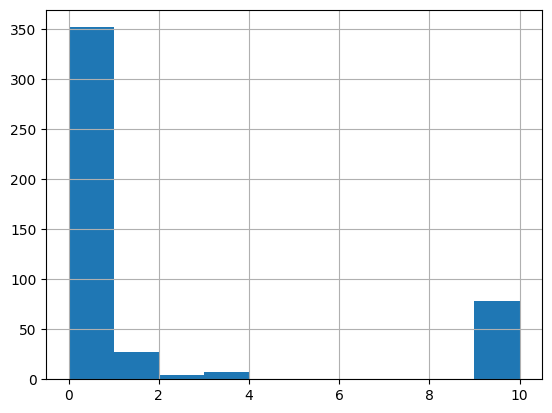

In [8]:
counters_assigned_df['way_ambiguity'].hist()

### Load loop counter speed values (2019-06-04 is a Tuesday)

In [9]:
loop_counter_speed_files = sorted(list((COUNTER_PATH / 'berlin' / 'speed').glob('*.parquet')))
loop_counter_speed_files[:3]

[PosixPath('/private/data/mets10/loop_counters/berlin/speed/counters_2019-06.parquet'),
 PosixPath('/private/data/mets10/loop_counters/berlin/speed/counters_2021-07.parquet')]

In [10]:
counter_speed_df = pd.read_parquet(COUNTER_PATH / 'berlin' / 'speed' / 'counters_2019-06.parquet')
counter_speed_df

,id,tag,stunde,qualitaet,q_kfz_det_hr,v_kfz_det_hr,q_pkw_det_hr,v_pkw_det_hr,q_lkw_det_hr,v_lkw_det_hr,name,heading,lane,lon,lat,time_bin
0,100101010000167,01.06.2019,0,1.0,227,82.8,207,83.9,20,71.6,TE001_Det_HF1,225,HF_R,13.192578,52.433868,2019-06-01 00:00
1,100101010000167,01.06.2019,1,1.0,131,78.4,115,80.5,16,63.7,TE001_Det_HF1,225,HF_R,13.192578,52.433868,2019-06-01 01:00
2,100101010000167,01.06.2019,2,1.0,94,77.0,74,80.6,20,63.3,TE001_Det_HF1,225,HF_R,13.192578,52.433868,2019-06-01 02:00
3,100101010000167,01.06.2019,3,1.0,83,76.4,68,76.2,15,77.3,TE001_Det_HF1,225,HF_R,13.192578,52.433868,2019-06-01 03:00
4,100101010000167,01.06.2019,4,1.0,131,76.9,118,78.8,13,59.9,TE001_Det_HF1,225,HF_R,13.192578,52.433868,2019-06-01 04:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
373734,100101010099995,30.06.2019,19,1.0,191,43.4,189,43.4,2,42.0,TE593_Det_HF2,0,HF_2vR,13.302183,52.508531,2019-06-30 19:00
373735,100101010099995,30.06.2019,20,1.0,219,42.2,216,42.4,3,27.3,TE593_Det_HF2,0,HF_2vR,13.302183,52.508531,2019-06-30 20:00
373736,100101010099995,30.06.2019,21,1.0,265,39.6,257,39.9,8,29.5,TE593_Det_HF2,0,HF_2vR,13.302183,52.508531,2019-06-30 21:00
373737,100101010099995,30.06.2019,22,1.0,158,43.2,157,43.3,1,42.0,TE593_Det_HF2,0,HF_2vR,13.302183,52.508531,2019-06-30 22:00


In [11]:
counter_speed_df['day'] = [tb[:10] for tb in counter_speed_df['time_bin']]
counter_speed_df['h'] = counter_speed_df['stunde']
counter_speed_df['speed_counter'] = counter_speed_df['v_kfz_det_hr'].astype(float)
counter_speed_df['volume'] = counter_speed_df['q_kfz_det_hr'].astype(int)
counter_speed_df = counter_speed_df[['id', 'day', 'h', 'speed_counter', 'volume']]
counter_speed_df

,id,day,h,speed_counter,volume
0,100101010000167,2019-06-01,0,82.8,227
1,100101010000167,2019-06-01,1,78.4,131
2,100101010000167,2019-06-01,2,77.0,94
3,100101010000167,2019-06-01,3,76.4,83
4,100101010000167,2019-06-01,4,76.9,131
...,...,...,...,...,...
373734,100101010099995,2019-06-30,19,43.4,191
373735,100101010099995,2019-06-30,20,42.2,219
373736,100101010099995,2019-06-30,21,39.6,265
373737,100101010099995,2019-06-30,22,43.2,158


In [12]:
# Select a single day and merge with the locations
counter_speeds_oneday = counter_speed_df[counter_speed_df['day'] == '2019-06-04'].merge(
    counters_assigned_df[['id', 'way', 'u', 'v']], on=['id'])
counter_speeds_oneday

,id,day,h,speed_counter,volume,way,u,v
0,100101010000167,2019-06-04,8,80.3,1118,150912137,268076575,1827856523
1,100101010000167,2019-06-04,9,75.4,968,150912137,268076575,1827856523
2,100101010000167,2019-06-04,10,71.3,993,150912137,268076575,1827856523
3,100101010000167,2019-06-04,11,71.4,994,150912137,268076575,1827856523
4,100101010000167,2019-06-04,12,68.8,979,150912137,268076575,1827856523
...,...,...,...,...,...,...,...,...
7306,100101010099995,2019-06-04,19,39.0,401,327805903,26736157,791127364
7307,100101010099995,2019-06-04,20,40.3,244,327805903,26736157,791127364
7308,100101010099995,2019-06-04,21,42.2,232,327805903,26736157,791127364
7309,100101010099995,2019-06-04,22,40.4,210,327805903,26736157,791127364


In [13]:
def is_valid_counter(s):
    h = np.histogram(s, bins=2)
    return h[-1][-1]

invalid_counters = counter_speeds_oneday[['id', 'speed_counter']].groupby(by=['id']).agg(list).reset_index()
invalid_counters['shist'] = [is_valid_counter(s) for s in invalid_counters['speed_counter']]
invalid_counters = invalid_counters[invalid_counters['shist'] < 1]
invalid_counters

,id,speed_counter,shist


In [14]:
counter_speeds_oneday = counter_speeds_oneday[~counter_speeds_oneday['id'].isin(invalid_counters['id'])]
counter_speeds_oneday

,id,day,h,speed_counter,volume,way,u,v
0,100101010000167,2019-06-04,8,80.3,1118,150912137,268076575,1827856523
1,100101010000167,2019-06-04,9,75.4,968,150912137,268076575,1827856523
2,100101010000167,2019-06-04,10,71.3,993,150912137,268076575,1827856523
3,100101010000167,2019-06-04,11,71.4,994,150912137,268076575,1827856523
4,100101010000167,2019-06-04,12,68.8,979,150912137,268076575,1827856523
...,...,...,...,...,...,...,...,...
7306,100101010099995,2019-06-04,19,39.0,401,327805903,26736157,791127364
7307,100101010099995,2019-06-04,20,40.3,244,327805903,26736157,791127364
7308,100101010099995,2019-06-04,21,42.2,232,327805903,26736157,791127364
7309,100101010099995,2019-06-04,22,40.4,210,327805903,26736157,791127364


### Load T4c speed values

In [15]:
speed_files = sorted(list((RELEASE_PATH / 'speed_classes' / 'berlin').glob('*.parquet')))
speed_files[-3:]

[PosixPath('/Users/neun/data/t4c/data_pipeline/validations_ext_uber/release20221028_historic_uber/speed_classes/berlin/speed_classes_2019-06-28.parquet'),
 PosixPath('/Users/neun/data/t4c/data_pipeline/validations_ext_uber/release20221028_historic_uber/speed_classes/berlin/speed_classes_2019-06-29.parquet'),
 PosixPath('/Users/neun/data/t4c/data_pipeline/validations_ext_uber/release20221028_historic_uber/speed_classes/berlin/speed_classes_2019-06-30.parquet')]

In [16]:
# speed_df = pd.read_parquet(speed_files[0])
speed_df = pd.read_parquet(RELEASE_PATH / 'speed_classes' / 'berlin' / 'speed_classes_2019-06-04.parquet')
speed_df = speed_df.rename(columns={'median_speed_kph': 'speed_probes'})
speed_df['h'] = (speed_df['t'] / 4).astype(int)
speed_df = speed_df[['u', 'v', 'gkey', 'osmid', 'day', 'h', 'volume', 'speed_probes']]
speed_df

,u,v,gkey,osmid,day,h,volume,speed_probes
0,172546,530313,172546_530313_24295532,24295532,2019-06-04,0,9.0,48.235294
1,172546,530313,172546_530313_24295532,24295532,2019-06-04,0,14.0,38.431373
2,172546,530313,172546_530313_24295532,24295532,2019-06-04,0,1.0,49.882353
3,172546,530313,172546_530313_24295532,24295532,2019-06-04,1,4.0,40.470588
4,172546,530313,172546_530313_24295532,24295532,2019-06-04,4,3.0,32.000000
...,...,...,...,...,...,...,...,...
1252269,6173378378,426425008,6173378378_426425008_132105452,132105452,2019-06-04,22,9.0,34.352941
1252270,6173378378,426425008,6173378378_426425008_132105452,132105452,2019-06-04,23,7.0,40.000000
1252271,6173378378,426425008,6173378378_426425008_132105452,132105452,2019-06-04,23,3.0,51.764706
1252272,6173378378,426425008,6173378378_426425008_132105452,132105452,2019-06-04,23,11.0,40.000000


In [17]:
speed_hour_df = speed_df.groupby(by=['u', 'v', 'gkey', 'osmid', 'day', 'h']).mean().reset_index()
speed_hour_df

,u,v,gkey,osmid,day,h,volume,speed_probes
0,172546,530313,172546_530313_24295532,24295532,2019-06-04,0,8.000000,45.516340
1,172546,530313,172546_530313_24295532,24295532,2019-06-04,1,4.000000,40.470588
2,172546,530313,172546_530313_24295532,24295532,2019-06-04,4,3.666667,38.274510
3,172546,530313,172546_530313_24295532,24295532,2019-06-04,5,5.666667,45.385621
4,172546,530313,172546_530313_24295532,24295532,2019-06-04,6,5.666667,42.274510
...,...,...,...,...,...,...,...,...
367760,6173378378,426425008,6173378378_426425008_132105452,132105452,2019-06-04,19,14.250000,32.137255
367761,6173378378,426425008,6173378378_426425008_132105452,132105452,2019-06-04,20,7.000000,35.529412
367762,6173378378,426425008,6173378378_426425008_132105452,132105452,2019-06-04,21,10.750000,35.568627
367763,6173378378,426425008,6173378378_426425008_132105452,132105452,2019-06-04,22,9.250000,34.039216


# Compare Speed Values

In [18]:
speeds_merged = counter_speeds_oneday.merge(speed_df, on=['u', 'v', 'h'])
speeds_merged

,id,day_x,h,speed_counter,volume_x,way,u,v,gkey,osmid,day_y,volume_y,speed_probes
0,100101010000167,2019-06-04,8,80.3,1118,150912137,268076575,1827856523,268076575_1827856523_150912137,150912137,2019-06-04,457.0,89.254902
1,100101010000167,2019-06-04,8,80.3,1118,150912137,268076575,1827856523,268076575_1827856523_150912137,150912137,2019-06-04,352.0,89.725490
2,100101010000167,2019-06-04,8,80.3,1118,150912137,268076575,1827856523,268076575_1827856523_150912137,150912137,2019-06-04,518.0,86.274510
3,100101010000167,2019-06-04,8,80.3,1118,150912137,268076575,1827856523,268076575_1827856523_150912137,150912137,2019-06-04,531.0,85.176471
4,100101010000268,2019-06-04,8,3.0,974,150912137,268076575,1827856523,268076575_1827856523_150912137,150912137,2019-06-04,457.0,89.254902
...,...,...,...,...,...,...,...,...,...,...,...,...,...
28502,100101010099894,2019-06-04,23,42.9,128,327805903,26736157,791127364,26736157_791127364_327805903,327805903,2019-06-04,22.0,37.764706
28503,100101010099995,2019-06-04,23,42.1,119,327805903,26736157,791127364,26736157_791127364_327805903,327805903,2019-06-04,30.0,38.352941
28504,100101010099995,2019-06-04,23,42.1,119,327805903,26736157,791127364,26736157_791127364_327805903,327805903,2019-06-04,29.0,44.470588
28505,100101010099995,2019-06-04,23,42.1,119,327805903,26736157,791127364,26736157_791127364_327805903,327805903,2019-06-04,11.0,15.764706


In [19]:
speeds_merged = speeds_merged[speeds_merged['volume_y'] > 0]
speeds_merged['diff'] = (speeds_merged['speed_counter'] - speeds_merged['speed_probes']).abs()
speeds_merged

,id,day_x,h,speed_counter,volume_x,way,u,v,gkey,osmid,day_y,volume_y,speed_probes,diff
0,100101010000167,2019-06-04,8,80.3,1118,150912137,268076575,1827856523,268076575_1827856523_150912137,150912137,2019-06-04,457.0,89.254902,8.954902
1,100101010000167,2019-06-04,8,80.3,1118,150912137,268076575,1827856523,268076575_1827856523_150912137,150912137,2019-06-04,352.0,89.725490,9.425490
2,100101010000167,2019-06-04,8,80.3,1118,150912137,268076575,1827856523,268076575_1827856523_150912137,150912137,2019-06-04,518.0,86.274510,5.974510
3,100101010000167,2019-06-04,8,80.3,1118,150912137,268076575,1827856523,268076575_1827856523_150912137,150912137,2019-06-04,531.0,85.176471,4.876471
4,100101010000268,2019-06-04,8,3.0,974,150912137,268076575,1827856523,268076575_1827856523_150912137,150912137,2019-06-04,457.0,89.254902,86.254902
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28502,100101010099894,2019-06-04,23,42.9,128,327805903,26736157,791127364,26736157_791127364_327805903,327805903,2019-06-04,22.0,37.764706,5.135294
28503,100101010099995,2019-06-04,23,42.1,119,327805903,26736157,791127364,26736157_791127364_327805903,327805903,2019-06-04,30.0,38.352941,3.747059
28504,100101010099995,2019-06-04,23,42.1,119,327805903,26736157,791127364,26736157_791127364_327805903,327805903,2019-06-04,29.0,44.470588,2.370588
28505,100101010099995,2019-06-04,23,42.1,119,327805903,26736157,791127364,26736157_791127364_327805903,327805903,2019-06-04,11.0,15.764706,26.335294


In [20]:
len(speeds_merged['id'].unique())

462

In [21]:
counters_speed_df = speeds_merged[['id', 'u', 'v', 'way']].groupby(by=['id', 'u', 'v', 'way']).count().reset_index()
counters_speed_df['way'] = counters_speed_df['way'].astype(str)
counters_stats_df = counters_speed_df.merge(edges_df, left_on=['u', 'v', 'way'], right_on=['u', 'v', 'osmid'])
counters_stats_df = counters_stats_df[['id', 'highway']]
counters_stats_df['hwc'] = counters_stats_df['highway'].str.replace('_link', '')
counters_stats_df['hwc'] = counters_stats_df['hwc'].str.replace('.*trunk.*', 'trunk')
counters_stats_df['hwc'] = counters_stats_df['hwc'].str.replace('.*primary.*', 'primary')
highway_stats = counters_stats_df[['hwc', 'highway']].groupby(by=['hwc']).count().reset_index()
highway_stats = highway_stats.rename(columns={'highway': 'count'})
highway_stats = highway_stats.rename(columns={'hwc': 'highway'})
highway_stats['share'] = (highway_stats['count'] / len(counters_stats_df) * 100).round()
highway_stats = highway_stats.set_index('highway')
highway_stats.style.format({'share': "{:.0f} %"})

/var/folders/dr/jy4_0c5d3q37snprz6rhwwt40000gn/T/ipykernel_70145/2805691077.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  counters_stats_df['hwc'] = counters_stats_df['hwc'].str.replace('.*trunk.*', 'trunk')
/var/folders/dr/jy4_0c5d3q37snprz6rhwwt40000gn/T/ipykernel_70145/2805691077.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  counters_stats_df['hwc'] = counters_stats_df['hwc'].str.replace('.*primary.*', 'primary')


,count,share
highway,,
motorway,4,1 %
primary,191,41 %
residential,4,1 %
secondary,244,53 %
tertiary,19,4 %


<AxesSubplot: >

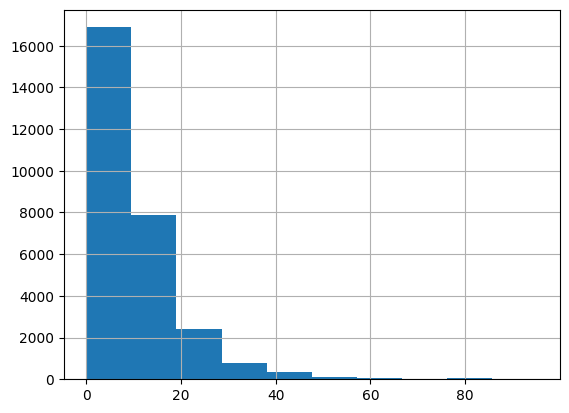

In [22]:
speeds_merged['diff'].hist()

In [23]:
speeds_merged = speeds_merged.merge(
    edges_df[['u', 'v', 'osmid', 'highway']], left_on=['u', 'v', 'way'], right_on=['u', 'v', 'osmid'])
speeds_merged

,id,day_x,h,speed_counter,volume_x,way,u,v,gkey,osmid_x,day_y,volume_y,speed_probes,diff,osmid_y,highway
0,100101010000167,2019-06-04,8,80.3,1118,150912137,268076575,1827856523,268076575_1827856523_150912137,150912137,2019-06-04,457.0,89.254902,8.954902,150912137,motorway
1,100101010000167,2019-06-04,8,80.3,1118,150912137,268076575,1827856523,268076575_1827856523_150912137,150912137,2019-06-04,352.0,89.725490,9.425490,150912137,motorway
2,100101010000167,2019-06-04,8,80.3,1118,150912137,268076575,1827856523,268076575_1827856523_150912137,150912137,2019-06-04,518.0,86.274510,5.974510,150912137,motorway
3,100101010000167,2019-06-04,8,80.3,1118,150912137,268076575,1827856523,268076575_1827856523_150912137,150912137,2019-06-04,531.0,85.176471,4.876471,150912137,motorway
4,100101010000268,2019-06-04,8,3.0,974,150912137,268076575,1827856523,268076575_1827856523_150912137,150912137,2019-06-04,457.0,89.254902,86.254902,150912137,motorway
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28502,100101010099894,2019-06-04,23,42.9,128,327805903,26736157,791127364,26736157_791127364_327805903,327805903,2019-06-04,22.0,37.764706,5.135294,327805903,secondary
28503,100101010099995,2019-06-04,23,42.1,119,327805903,26736157,791127364,26736157_791127364_327805903,327805903,2019-06-04,30.0,38.352941,3.747059,327805903,secondary
28504,100101010099995,2019-06-04,23,42.1,119,327805903,26736157,791127364,26736157_791127364_327805903,327805903,2019-06-04,29.0,44.470588,2.370588,327805903,secondary
28505,100101010099995,2019-06-04,23,42.1,119,327805903,26736157,791127364,26736157_791127364_327805903,327805903,2019-06-04,11.0,15.764706,26.335294,327805903,secondary


In [24]:
speeds_merged_hourly = speeds_merged.groupby(['id', 'u', 'v', 'gkey', 'h', 'highway']).mean()
speeds_merged_hourly = speeds_merged_hourly[['speed_counter', 'speed_probes']].reset_index()
speeds_merged_hourly = speeds_merged_hourly.rename(columns={'h': 'hour'})
speeds_merged_hourly

/var/folders/dr/jy4_0c5d3q37snprz6rhwwt40000gn/T/ipykernel_70145/1917398406.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  speeds_merged_hourly = speeds_merged.groupby(['id', 'u', 'v', 'gkey', 'h', 'highway']).mean()


,id,u,v,gkey,hour,highway,speed_counter,speed_probes
0,100101010000167,268076575,1827856523,268076575_1827856523_150912137,8,motorway,80.3,87.607843
1,100101010000167,268076575,1827856523,268076575_1827856523_150912137,9,motorway,75.4,88.372549
2,100101010000167,268076575,1827856523,268076575_1827856523_150912137,10,motorway,71.3,87.450980
3,100101010000167,268076575,1827856523,268076575_1827856523_150912137,11,motorway,71.4,88.784314
4,100101010000167,268076575,1827856523,268076575_1827856523_150912137,12,motorway,68.8,87.470588
...,...,...,...,...,...,...,...,...
7281,100101010099995,26736157,791127364,26736157_791127364_327805903,19,secondary,39.0,25.284314
7282,100101010099995,26736157,791127364,26736157_791127364_327805903,20,secondary,40.3,35.627451
7283,100101010099995,26736157,791127364,26736157_791127364_327805903,21,secondary,42.2,29.696078
7284,100101010099995,26736157,791127364,26736157_791127364_327805903,22,secondary,40.4,38.588235


In [25]:
UBASEPATH = UBER_BASE / 'uber'
CITY = 'berlin'
YEAR = 2019
MONTH = 6
START_DAY = 4
END_DAY = 4  # incl.
uspeeds_df = pd.read_parquet(UBASEPATH / f"movement-speeds-hourly-{CITY}-{YEAR}-{MONTH}.parquet")
uspeeds_df = uspeeds_df[(uspeeds_df["day"] >= START_DAY) & (uspeeds_df["day"] <= END_DAY)]
# uspeeds_df["speed_kph_mean"] = uspeeds_df["speed_mph_mean"] * 1.60934
uspeeds_df = uspeeds_df.rename(
    columns={"osm_start_node_id": "u", "osm_end_node_id": "v", "osm_way_id": "osmid"})
uspeeds_df["gkey"] = [f"{u}_{v}_{osmid}" for u, v, osmid in zip(
    uspeeds_df["u"], uspeeds_df["v"], uspeeds_df["osmid"])]
uspeeds_df

,year,month,day,hour,utc_timestamp,segment_id,start_junction_id,end_junction_id,osmid,u,v,speed_kph_mean,speed_kph_stddev,gkey
47,2019,6,4,22,2019-06-04T20:00:00.000Z,2a4cd117e8b758cde331b8fca96ebfa5482a53eb,871dbeee4e706cae8b95be11a608707166267e0c,2d5f878e230c20918c1d335c180e2b041e7c0766,30253522,29826350,4998526579,43.610,4.824,29826350_4998526579_30253522
54,2019,6,4,19,2019-06-04T17:00:00.000Z,2a4cd117e8b758cde331b8fca96ebfa5482a53eb,871dbeee4e706cae8b95be11a608707166267e0c,2d5f878e230c20918c1d335c180e2b041e7c0766,30253522,29826350,4998526579,50.168,10.629,29826350_4998526579_30253522
115,2019,6,4,18,2019-06-04T16:00:00.000Z,2a4cd117e8b758cde331b8fca96ebfa5482a53eb,871dbeee4e706cae8b95be11a608707166267e0c,2d5f878e230c20918c1d335c180e2b041e7c0766,30253522,29826350,4998526579,49.888,4.216,29826350_4998526579_30253522
132,2019,6,4,23,2019-06-04T21:00:00.000Z,2a4cd117e8b758cde331b8fca96ebfa5482a53eb,871dbeee4e706cae8b95be11a608707166267e0c,2d5f878e230c20918c1d335c180e2b041e7c0766,30253522,29826350,4998526579,50.456,7.304,29826350_4998526579_30253522
185,2019,6,4,20,2019-06-04T18:00:00.000Z,2a4cd117e8b758cde331b8fca96ebfa5482a53eb,871dbeee4e706cae8b95be11a608707166267e0c,2d5f878e230c20918c1d335c180e2b041e7c0766,30253522,29826350,4998526579,44.440,3.595,29826350_4998526579_30253522
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2409186,2019,6,4,17,2019-06-04T15:00:00.000Z,ff8a397700e1b9293bad2c93cd1a03aedf5ae6f5,9a51ec7772c9bbf6375eeace41d2a4a62cca64e3,7205366afb085f05d29e3698481f57b08693cd30,4446505,1277848884,27306422,45.154,8.976,1277848884_27306422_4446505
2409188,2019,6,4,1,2019-06-03T23:00:00.000Z,ff8a397700e1b9293bad2c93cd1a03aedf5ae6f5,9a51ec7772c9bbf6375eeace41d2a4a62cca64e3,7205366afb085f05d29e3698481f57b08693cd30,4446505,1277848884,27306422,46.102,9.870,1277848884_27306422_4446505
2409217,2019,6,4,16,2019-06-04T14:00:00.000Z,ff8a397700e1b9293bad2c93cd1a03aedf5ae6f5,9a51ec7772c9bbf6375eeace41d2a4a62cca64e3,7205366afb085f05d29e3698481f57b08693cd30,4446505,1277848884,27306422,43.108,7.228,1277848884_27306422_4446505
2409218,2019,6,4,20,2019-06-04T18:00:00.000Z,ff8a397700e1b9293bad2c93cd1a03aedf5ae6f5,9a51ec7772c9bbf6375eeace41d2a4a62cca64e3,7205366afb085f05d29e3698481f57b08693cd30,4446505,1277848884,27306422,46.875,6.227,1277848884_27306422_4446505


In [26]:
usm = speeds_merged_hourly.merge(uspeeds_df, on=['u', 'v', 'gkey', 'hour'])
usm

,id,u,v,gkey,hour,highway,speed_counter,speed_probes,year,month,day,utc_timestamp,segment_id,start_junction_id,end_junction_id,osmid,speed_kph_mean,speed_kph_stddev
0,100101010000167,268076575,1827856523,268076575_1827856523_150912137,8,motorway,80.3,87.607843,2019,6,4,2019-06-04T06:00:00.000Z,ac72f4dadf5b1c797276e5bed9736d1b0df45b8a,0943b659adff682f16d00d7d4599e8e1faa54182,44675f85c30895b25b4d34502d1d0ef05f98949b,150912137,87.693,8.846
1,100101010000268,268076575,1827856523,268076575_1827856523_150912137,8,motorway,3.0,87.607843,2019,6,4,2019-06-04T06:00:00.000Z,ac72f4dadf5b1c797276e5bed9736d1b0df45b8a,0943b659adff682f16d00d7d4599e8e1faa54182,44675f85c30895b25b4d34502d1d0ef05f98949b,150912137,87.693,8.846
2,100101010000369,268076575,1827856523,268076575_1827856523_150912137,8,motorway,64.4,87.607843,2019,6,4,2019-06-04T06:00:00.000Z,ac72f4dadf5b1c797276e5bed9736d1b0df45b8a,0943b659adff682f16d00d7d4599e8e1faa54182,44675f85c30895b25b4d34502d1d0ef05f98949b,150912137,87.693,8.846
3,100101010000470,268076575,1827856523,268076575_1827856523_150912137,8,motorway,67.0,87.607843,2019,6,4,2019-06-04T06:00:00.000Z,ac72f4dadf5b1c797276e5bed9736d1b0df45b8a,0943b659adff682f16d00d7d4599e8e1faa54182,44675f85c30895b25b4d34502d1d0ef05f98949b,150912137,87.693,8.846
4,100101010007948,311181577,311181586,311181577_311181586_377739469,8,primary,30.2,28.784314,2019,6,4,2019-06-04T06:00:00.000Z,68a21811316a702ccec8092adc35fd10419e5741,c37e260ef1b1cb44c2d57c9dad825cab968ace12,60c7ec0d9db8ddc206d636543efceef5181115b7,377739469,23.936,17.191
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3031,100101010099793,26736176,26736175,26736176_26736175_31621007,9,secondary,39.1,21.549020,2019,6,4,2019-06-04T07:00:00.000Z,7349e7c8d3be6ac4ae736d562fadc602c8b8e866,c1f4c15ece91335b65593288cd13a1d3919dfb4a,df8b1c73b59cc1defb3bf29fba29bd89aec9c58e,31621007,17.264,6.404
3032,100101010099692,26736176,26736175,26736176_26736175_31621007,13,secondary,37.1,22.029412,2019,6,4,2019-06-04T11:00:00.000Z,7349e7c8d3be6ac4ae736d562fadc602c8b8e866,c1f4c15ece91335b65593288cd13a1d3919dfb4a,df8b1c73b59cc1defb3bf29fba29bd89aec9c58e,31621007,19.967,8.742
3033,100101010099793,26736176,26736175,26736176_26736175_31621007,13,secondary,42.5,22.029412,2019,6,4,2019-06-04T11:00:00.000Z,7349e7c8d3be6ac4ae736d562fadc602c8b8e866,c1f4c15ece91335b65593288cd13a1d3919dfb4a,df8b1c73b59cc1defb3bf29fba29bd89aec9c58e,31621007,19.967,8.742
3034,100101010099692,26736176,26736175,26736176_26736175_31621007,16,secondary,35.3,21.588235,2019,6,4,2019-06-04T14:00:00.000Z,7349e7c8d3be6ac4ae736d562fadc602c8b8e866,c1f4c15ece91335b65593288cd13a1d3919dfb4a,df8b1c73b59cc1defb3bf29fba29bd89aec9c58e,31621007,14.503,6.484


In [27]:
usm['diff'] = (usm['speed_counter'] - usm['speed_kph_mean']).abs()
usm

,id,u,v,gkey,hour,highway,speed_counter,speed_probes,year,month,day,utc_timestamp,segment_id,start_junction_id,end_junction_id,osmid,speed_kph_mean,speed_kph_stddev,diff
0,100101010000167,268076575,1827856523,268076575_1827856523_150912137,8,motorway,80.3,87.607843,2019,6,4,2019-06-04T06:00:00.000Z,ac72f4dadf5b1c797276e5bed9736d1b0df45b8a,0943b659adff682f16d00d7d4599e8e1faa54182,44675f85c30895b25b4d34502d1d0ef05f98949b,150912137,87.693,8.846,7.393
1,100101010000268,268076575,1827856523,268076575_1827856523_150912137,8,motorway,3.0,87.607843,2019,6,4,2019-06-04T06:00:00.000Z,ac72f4dadf5b1c797276e5bed9736d1b0df45b8a,0943b659adff682f16d00d7d4599e8e1faa54182,44675f85c30895b25b4d34502d1d0ef05f98949b,150912137,87.693,8.846,84.693
2,100101010000369,268076575,1827856523,268076575_1827856523_150912137,8,motorway,64.4,87.607843,2019,6,4,2019-06-04T06:00:00.000Z,ac72f4dadf5b1c797276e5bed9736d1b0df45b8a,0943b659adff682f16d00d7d4599e8e1faa54182,44675f85c30895b25b4d34502d1d0ef05f98949b,150912137,87.693,8.846,23.293
3,100101010000470,268076575,1827856523,268076575_1827856523_150912137,8,motorway,67.0,87.607843,2019,6,4,2019-06-04T06:00:00.000Z,ac72f4dadf5b1c797276e5bed9736d1b0df45b8a,0943b659adff682f16d00d7d4599e8e1faa54182,44675f85c30895b25b4d34502d1d0ef05f98949b,150912137,87.693,8.846,20.693
4,100101010007948,311181577,311181586,311181577_311181586_377739469,8,primary,30.2,28.784314,2019,6,4,2019-06-04T06:00:00.000Z,68a21811316a702ccec8092adc35fd10419e5741,c37e260ef1b1cb44c2d57c9dad825cab968ace12,60c7ec0d9db8ddc206d636543efceef5181115b7,377739469,23.936,17.191,6.264
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3031,100101010099793,26736176,26736175,26736176_26736175_31621007,9,secondary,39.1,21.549020,2019,6,4,2019-06-04T07:00:00.000Z,7349e7c8d3be6ac4ae736d562fadc602c8b8e866,c1f4c15ece91335b65593288cd13a1d3919dfb4a,df8b1c73b59cc1defb3bf29fba29bd89aec9c58e,31621007,17.264,6.404,21.836
3032,100101010099692,26736176,26736175,26736176_26736175_31621007,13,secondary,37.1,22.029412,2019,6,4,2019-06-04T11:00:00.000Z,7349e7c8d3be6ac4ae736d562fadc602c8b8e866,c1f4c15ece91335b65593288cd13a1d3919dfb4a,df8b1c73b59cc1defb3bf29fba29bd89aec9c58e,31621007,19.967,8.742,17.133
3033,100101010099793,26736176,26736175,26736176_26736175_31621007,13,secondary,42.5,22.029412,2019,6,4,2019-06-04T11:00:00.000Z,7349e7c8d3be6ac4ae736d562fadc602c8b8e866,c1f4c15ece91335b65593288cd13a1d3919dfb4a,df8b1c73b59cc1defb3bf29fba29bd89aec9c58e,31621007,19.967,8.742,22.533
3034,100101010099692,26736176,26736175,26736176_26736175_31621007,16,secondary,35.3,21.588235,2019,6,4,2019-06-04T14:00:00.000Z,7349e7c8d3be6ac4ae736d562fadc602c8b8e866,c1f4c15ece91335b65593288cd13a1d3919dfb4a,df8b1c73b59cc1defb3bf29fba29bd89aec9c58e,31621007,14.503,6.484,20.797


<AxesSubplot: >

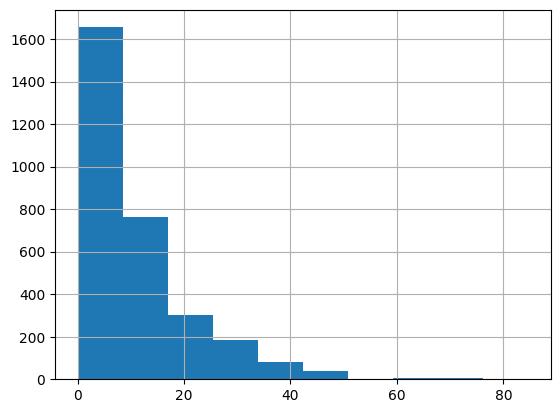

In [28]:
usm['diff'].hist()

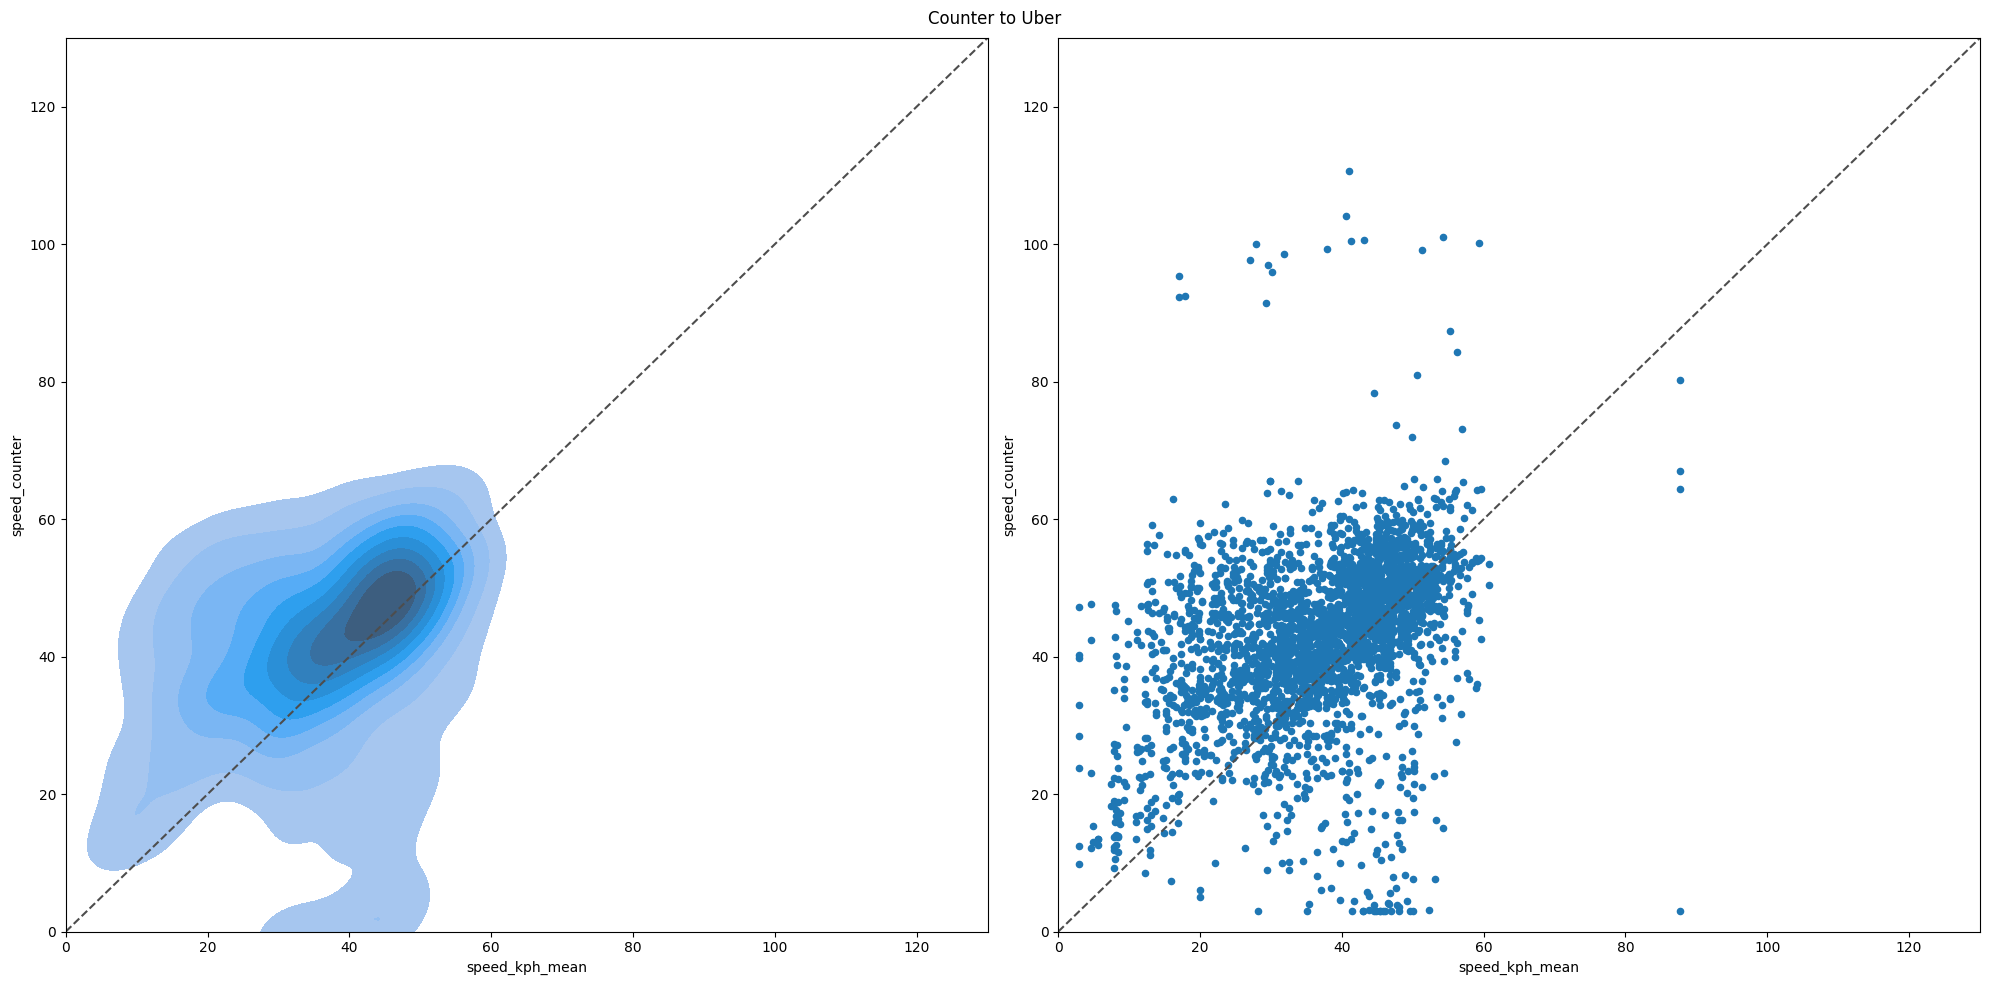

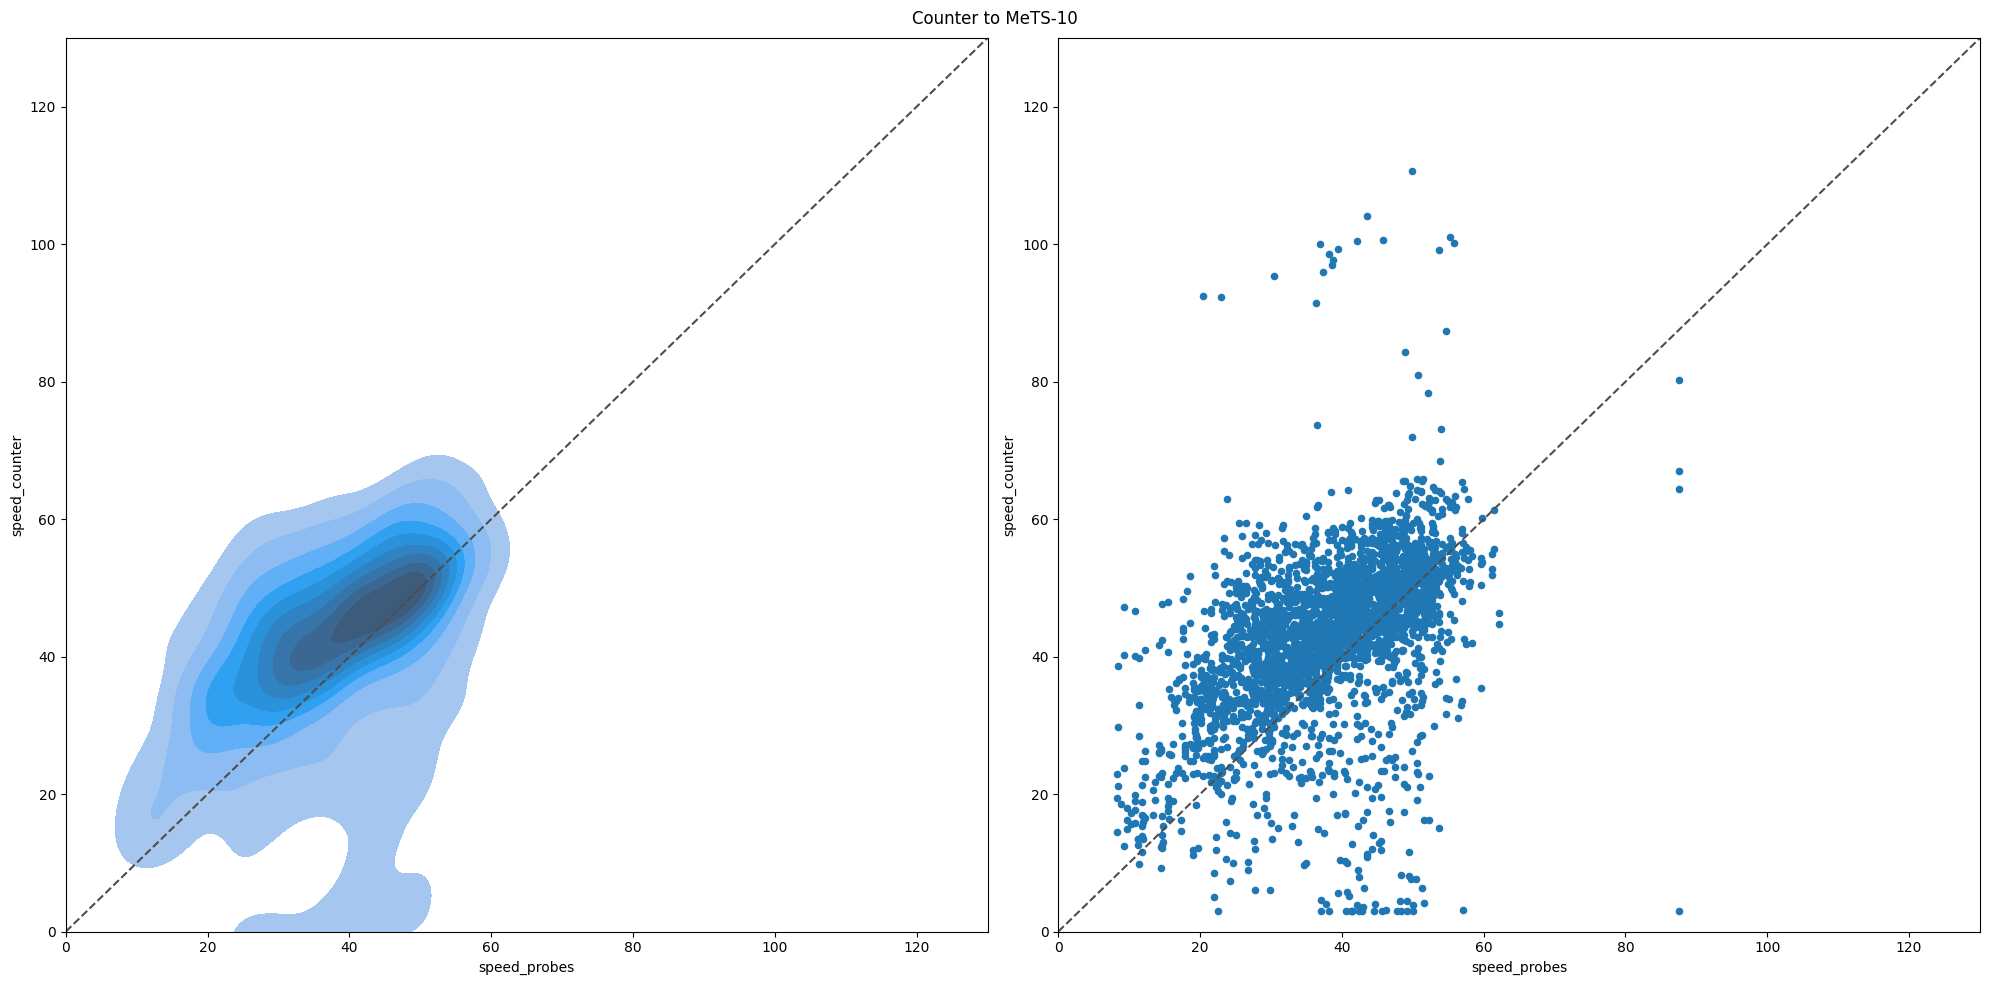

In [29]:
def plot_kde_scatter(df, ax, city=None, labelsize=24, titlesize=36, x_field='speed_probes'):
    ax.plot([0, 130], [0, 130], ls="--", c=".3")
    ax.set_xlim([0,130])
    ax.set_ylim([0,130])
    sns.kdeplot(data=df, x=x_field, y='speed_counter', fill=True, levels=10, ax=ax)
    if city:
        ax.set_xlabel(f'MeTS-10 Speed [km/h]', fontsize=titlesize)
        ax.set_ylabel('Detector Speed [km/h]', fontsize=titlesize)
        ax.tick_params(axis='x', which='major', labelsize=labelsize)
        ax.tick_params(axis='y', which='major', labelsize=labelsize)
        ax.title.set_text(city)
        ax.title.set_size(titlesize)

def plot_scatters(df, t_from=None, t_to=None, title=None, x_field='speed_probes'):
    if t_from and t_to:
        df = df[(df['t'] >= t_from) & (df['t'] < t_to)]
    fig, axs = plt.subplots(1, 2, tight_layout=True, figsize=(20,10))
    if title:
        fig.suptitle(title)
    ax = axs[0]
    plot_kde_scatter(df, ax, x_field=x_field)
    ax = axs[1]
    ax.plot([0, 130], [0, 130], ls="--", c=".3")
    ax.set_xlim([0,130])
    ax.set_ylim([0,130])
    df.plot(x=x_field, y='speed_counter', kind='scatter', ax=ax)

plot_scatters(usm, title='Counter to Uber', x_field='speed_kph_mean')
plot_scatters(usm, title='Counter to MeTS-10')

In [30]:
usm['id'].unique()

array([100101010000167, 100101010000268, 100101010000369, 100101010000470,
       100101010007948, 100101010008049, 100101010008150, 100101010008251,
       100101010009867, 100101010009968, 100101010010069, 100101010011887,
       100101010011988, 100101010012796, 100101010012800, 100101010012901,
       100101010013002, 100101010013103, 100101010013204, 100101010013305,
       100101010013406, 100101010014113, 100101010014214, 100101010014315,
       100101010014416, 100101010014517, 100101010014618, 100101010014719,
       100101010014820, 100101010014921, 100101010015022, 100101010015123,
       100101010015224, 100101010015325, 100101010015426, 100101010015527,
       100101010015628, 100101010015729, 100101010015830, 100101010016739,
       100101010016840, 100101010016941, 100101010017042, 100101010017143,
       100101010017244, 100101010017547, 100101010017648, 100101010021688,
       100101010021789, 100101010021890, 100101010021991, 100101010022092,
       100101010022193, 1

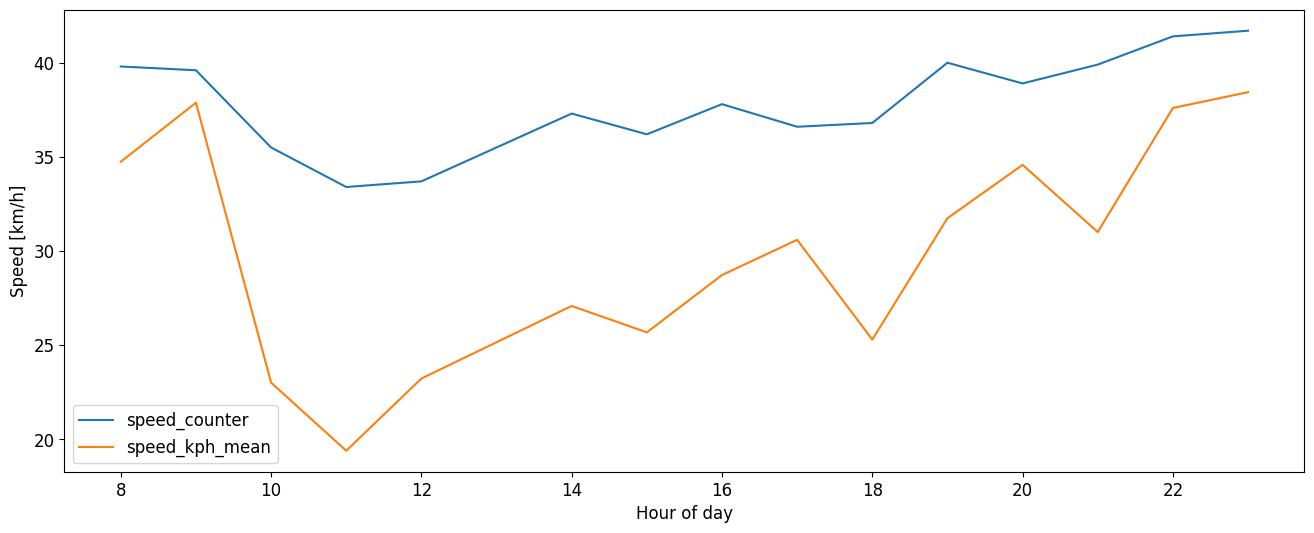

In [31]:
def plot_speed_dayline(df, id, x_field="t", plot_volume=False, figsize=(16,6), labels={}, labelsize=12, ax=None):
    cols = ["speed_counter", "speed_kph_mean"]
    label_names = ["speed_counter", "speed_kph_mean"]
    if not ax:
        fig, ax = plt.subplots(1, 1, figsize=figsize)
    df[df['id'] == id].plot(x=x_field, y=cols, label=label_names, fontsize=labelsize, ax=ax)
    ax.set_ylabel('Speed [km/h]', fontsize=labelsize)
    ax.set_xlabel('Hour of day', fontsize=labelsize)
    plt.legend(fontsize=labelsize)

plot_speed_dayline(usm, 100101010093733, x_field="hour")
plot_counter(counters_assigned_df, edges_df, 100101010093733)

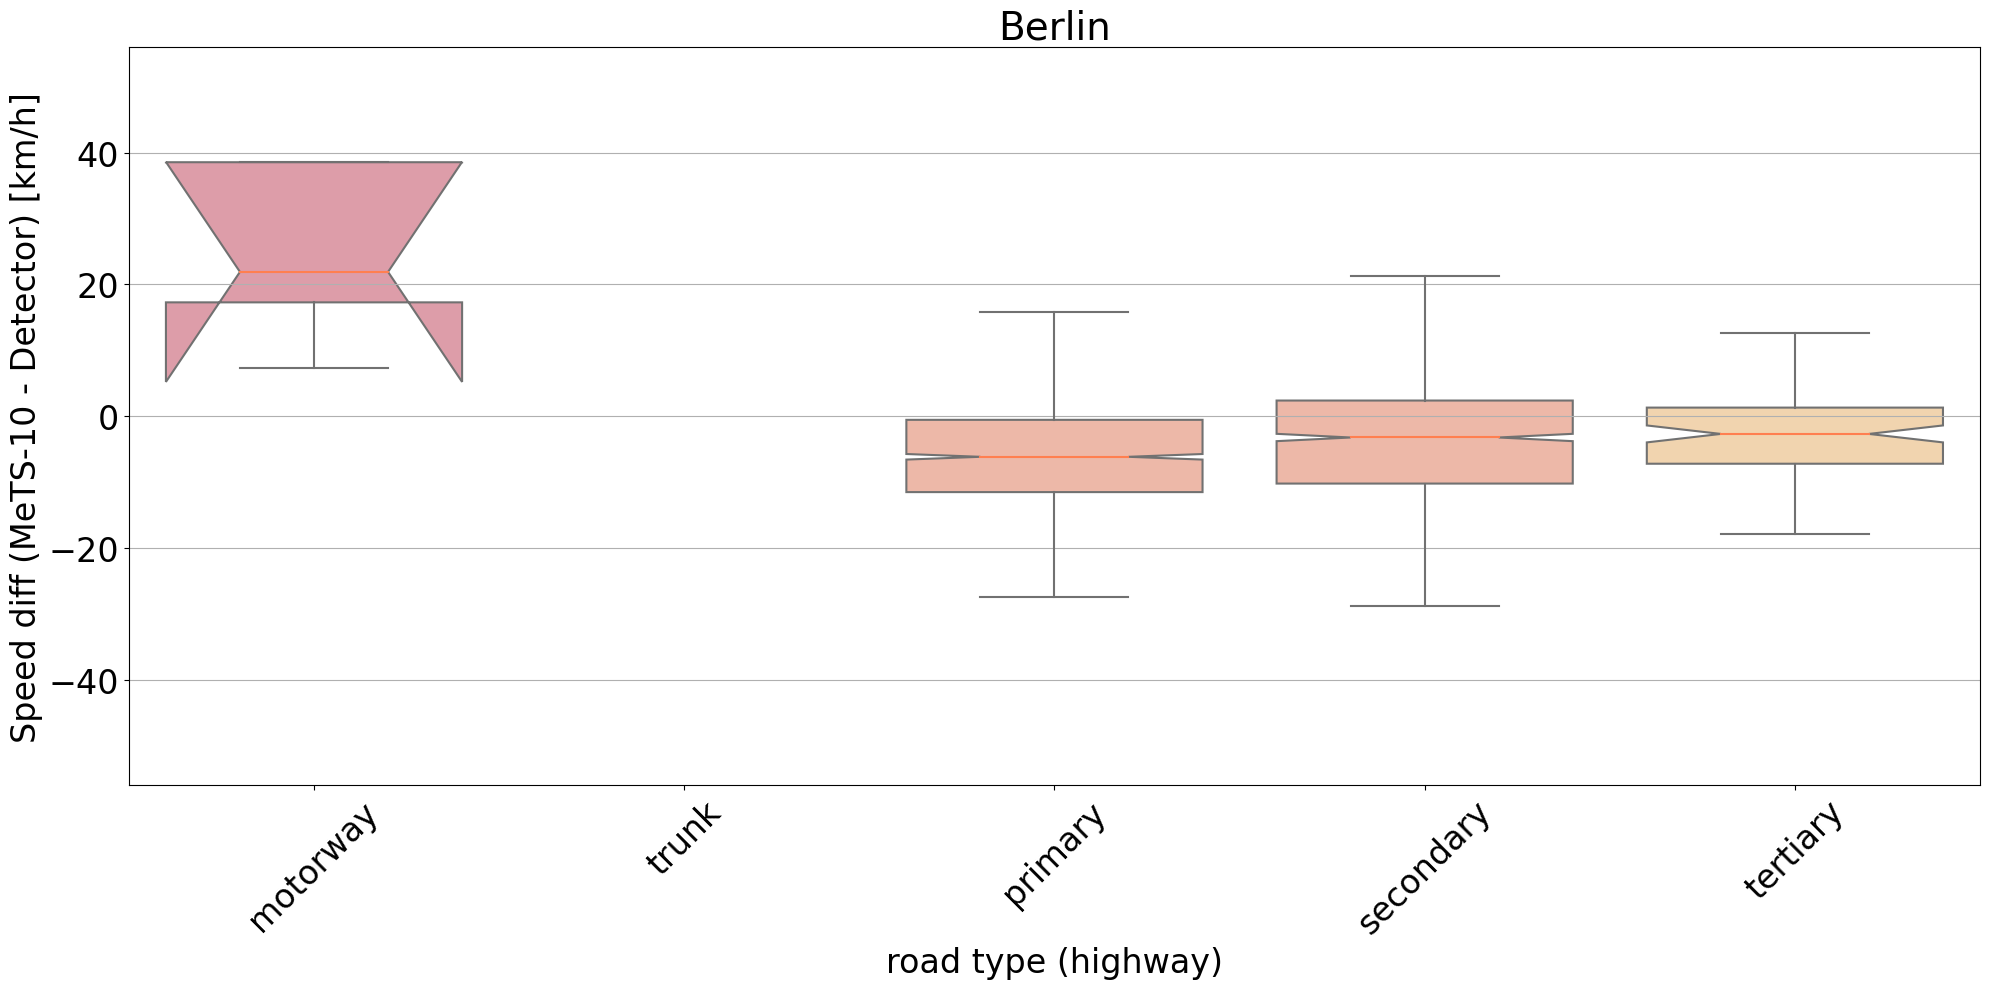

In [32]:
def osm_color_palette():
    for c in ["#e892a2", "#e892a2", "#f9b29c", "#f9b29c", "#fcd6a4", "#fcd6a4", "#f7fabf", "#f7fabf"] + ["white"] * 99:
        yield c

highway_ordering = [
    'motorway', 'motorway_link', 
    'trunk','trunk_link', 
    'primary','primary_link',
    'secondary', 'secondary_link', 
    'tertiary','tertiary_link',
    'unclassified',  'residential',
    'living_street', 'service',
    'cycleway', 'road', 'construction'
]
        
def diff_boxplot(data, ax=None, labelsize=24, city=''):
    data = data[~data['highway'].str.contains('_link')].copy()
    data.loc[data["highway"].str.contains('motorway'), "highway"] = "motorway"
    data.loc[data["highway"].str.contains('trunk'), "highway"] = "trunk"
    data.loc[data["highway"].str.contains('primary'), "highway"] = "primary"
    data["sort_key"] = [highway_ordering.index(hw) for hw in data["highway"]]
    data = data.sort_values("sort_key")
    data["diff_km"] = data['speed_probes'] - data['speed_counter']
    if not ax:
        fig, ax = plt.subplots(1, figsize=(20, 10), tight_layout=True)
    sns.boxplot(data=data, 
                x="highway",
                y="diff_km",  
                notch=True, 
                sym='',
                order=['motorway', 'trunk', 'primary', 'secondary', 'tertiary'],
                palette=osm_color_palette(),
                medianprops={"color": "coral"},
                ax=ax)
    ax.set(ylim=(-56, 56))
    ax.set_xlabel('road type (highway)', fontsize=labelsize)
    ax.set_ylabel('Speed diff (MeTS-10 - Detector) [km/h]', fontsize=labelsize)
    ax.tick_params(axis='x', which='major', labelsize=labelsize, rotation=45)
    ax.tick_params(axis='y', which='major', labelsize=labelsize)
    ax.grid(axis='y')
    ax.title.set_text(city)
    ax.title.set_size(labelsize+4)


diff_boxplot(usm, city='Berlin')
# plt.savefig("berlin_counter_uber_diff.png")

In [33]:
usm.to_parquet(COUNTER_PATH / 'berlin' / 'speeds_merged_uber_berlin.parquet', compression="snappy")